# Доверительные интервалы для оценки среднего

In [1]:
import numpy as np

from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [3]:
blobs = datasets \
        .make_blobs(300,
                    centers = 2,
                    cluster_std = 6,
                    random_state = 1)

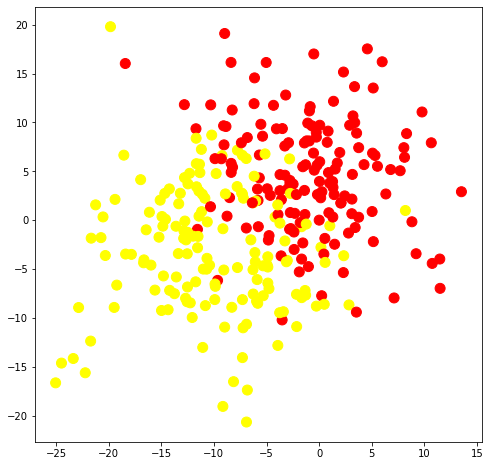

In [4]:
pylab.figure(figsize(8, 8))

pylab.scatter(list(map(lambda x: x[0], blobs[0])),
              list(map(lambda x: x[1], blobs[0])),
              c = blobs[1],
              cmap = 'autumn',
              s = 100)

## Сравнение линейных моделей

### Точечная оценка

In [5]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(blobs[0],
                                                                                    blobs[1],
                                                                                    test_size = 15,
                                                                                    random_state = 1)

In [10]:
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels,
                      ridge_model.predict(test_data))

0.8888888888888888

In [11]:
sgd_model = linear_model.SGDClassifier(random_state = 0, max_iter = 1000)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels,
                      sgd_model.predict(test_data))

0.7777777777777778

### Оценка среднего

In [12]:
sgd_auc_scores = model_selection \
                 .cross_val_score(linear_model.SGDClassifier(max_iter = 1000),
                                  blobs[0],
                                  blobs[1],
                                  scoring = 'roc_auc',
                                  cv = 20)

In [14]:
sgd_auc_scores

array([0.89285714, 0.91071429, 0.92857143, 0.91071429, 1.        ,
       0.98214286, 0.76785714, 1.        , 0.91071429, 1.        ,
       0.76785714, 0.96428571, 0.94642857, 0.91071429, 0.94642857,
       0.98214286, 0.82142857, 0.98214286, 0.94642857, 0.96428571])

In [13]:
ridge_auc_scores = model_selection \
                   .cross_val_score(linear_model.RidgeClassifier(), 
                                    blobs[0],
                                    blobs[1],
                                    scoring = 'roc_auc',
                                    cv = 20)

In [15]:
ridge_auc_scores

array([1.        , 0.89285714, 0.92857143, 0.89285714, 0.98214286,
       1.        , 0.73214286, 1.        , 0.92857143, 1.        ,
       0.85714286, 0.96428571, 0.91071429, 0.96428571, 0.98214286,
       1.        , 0.82142857, 0.98214286, 0.98214286, 0.91071429])

### Точечная оценка среднего

In [16]:
print("sgd model auc: mean %.3f, std %.3f" % (sgd_auc_scores.mean(),
                                              sgd_auc_scores.std(ddof=1)))

print("ridge model auc: mean %.3f, std %.3f" % (ridge_auc_scores.mean(),
                                                ridge_auc_scores.std(ddof=1)))

sgd model auc: mean 0.927, std 0.070
ridge model auc: mean 0.937, std 0.071


### Интервальная оценка среднего 

In [17]:
from statsmodels.stats.weightstats import _zconfint_generic
from statsmodels.stats.weightstats import _tconfint_generic

In [18]:
sgd_mean   = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()

#### z-интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [19]:
print("sgd model mean auc 95%% confidence interval",
      _zconfint_generic(sgd_auc_scores.mean(),
                        sqrt(0.25/len(sgd_auc_scores)),
                        0.05,
                        'two-sided'))

print("ridge model mean auc 95%% confidence interval",
      _zconfint_generic(ridge_auc_scores.mean(),
                        sqrt(0.25/len(sgd_auc_scores)),
                        0.05,
                        'two-sided'))

sgd model mean auc 95%% confidence interval (0.7076550791415688, 1.1459163494298596)
ridge model mean auc 95%% confidence interval (0.7174765077129974, 1.155737778001288)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [20]:
type(sgd_auc_scores)

numpy.ndarray

In [22]:
sgd_mean_std   = sgd_auc_scores.std(ddof=1) / sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1) / sqrt(len(ridge_auc_scores))

In [24]:
print("sgd model mean auc 95%% confidence interval",
      _tconfint_generic(sgd_mean,
                        sgd_mean_std,
                        len(sgd_auc_scores) - 1,
                        0.05,
                        'two-sided'))

print("ridge model mean auc 95%% confidence interval",
      _tconfint_generic(ridge_mean,
                        ridge_mean_std,
                        len(sgd_auc_scores) - 1,
                        0.05,
                        'two-sided'))

sgd model mean auc 95%% confidence interval (0.8940337736585048, 0.9595376549129236)
ridge model mean auc 95%% confidence interval (0.903235324375978, 0.9699789613383075)


# Решение теста

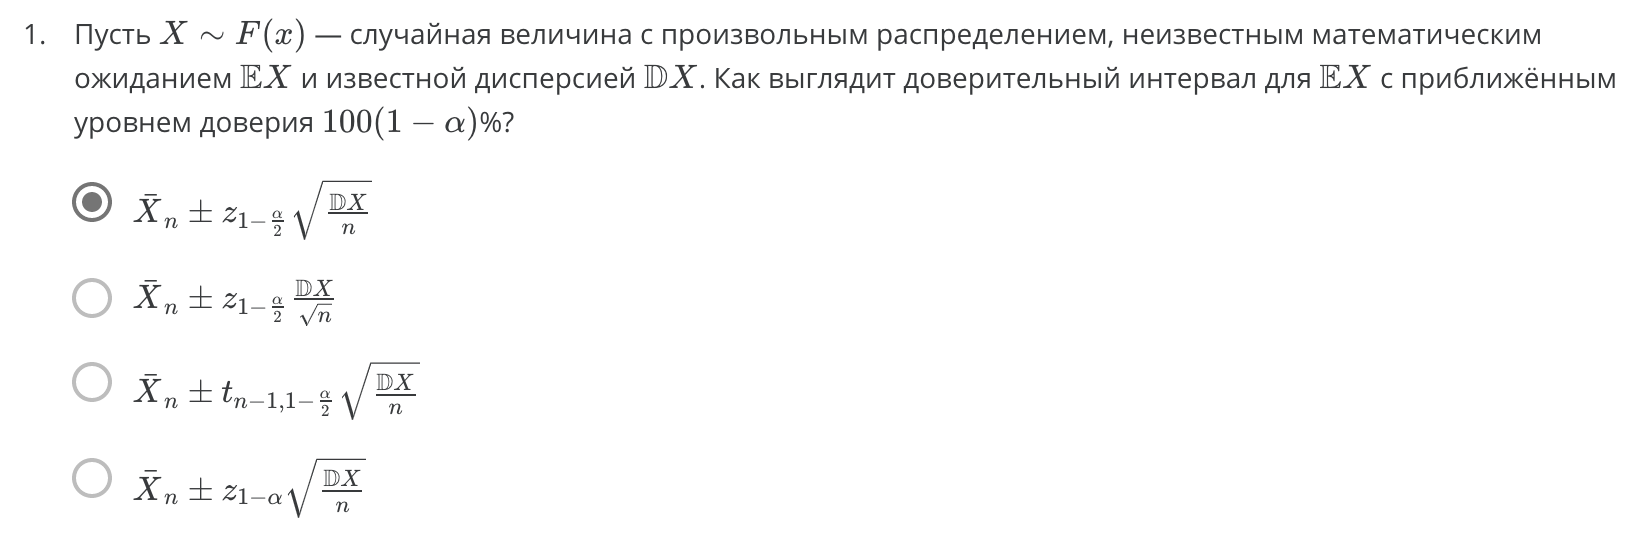

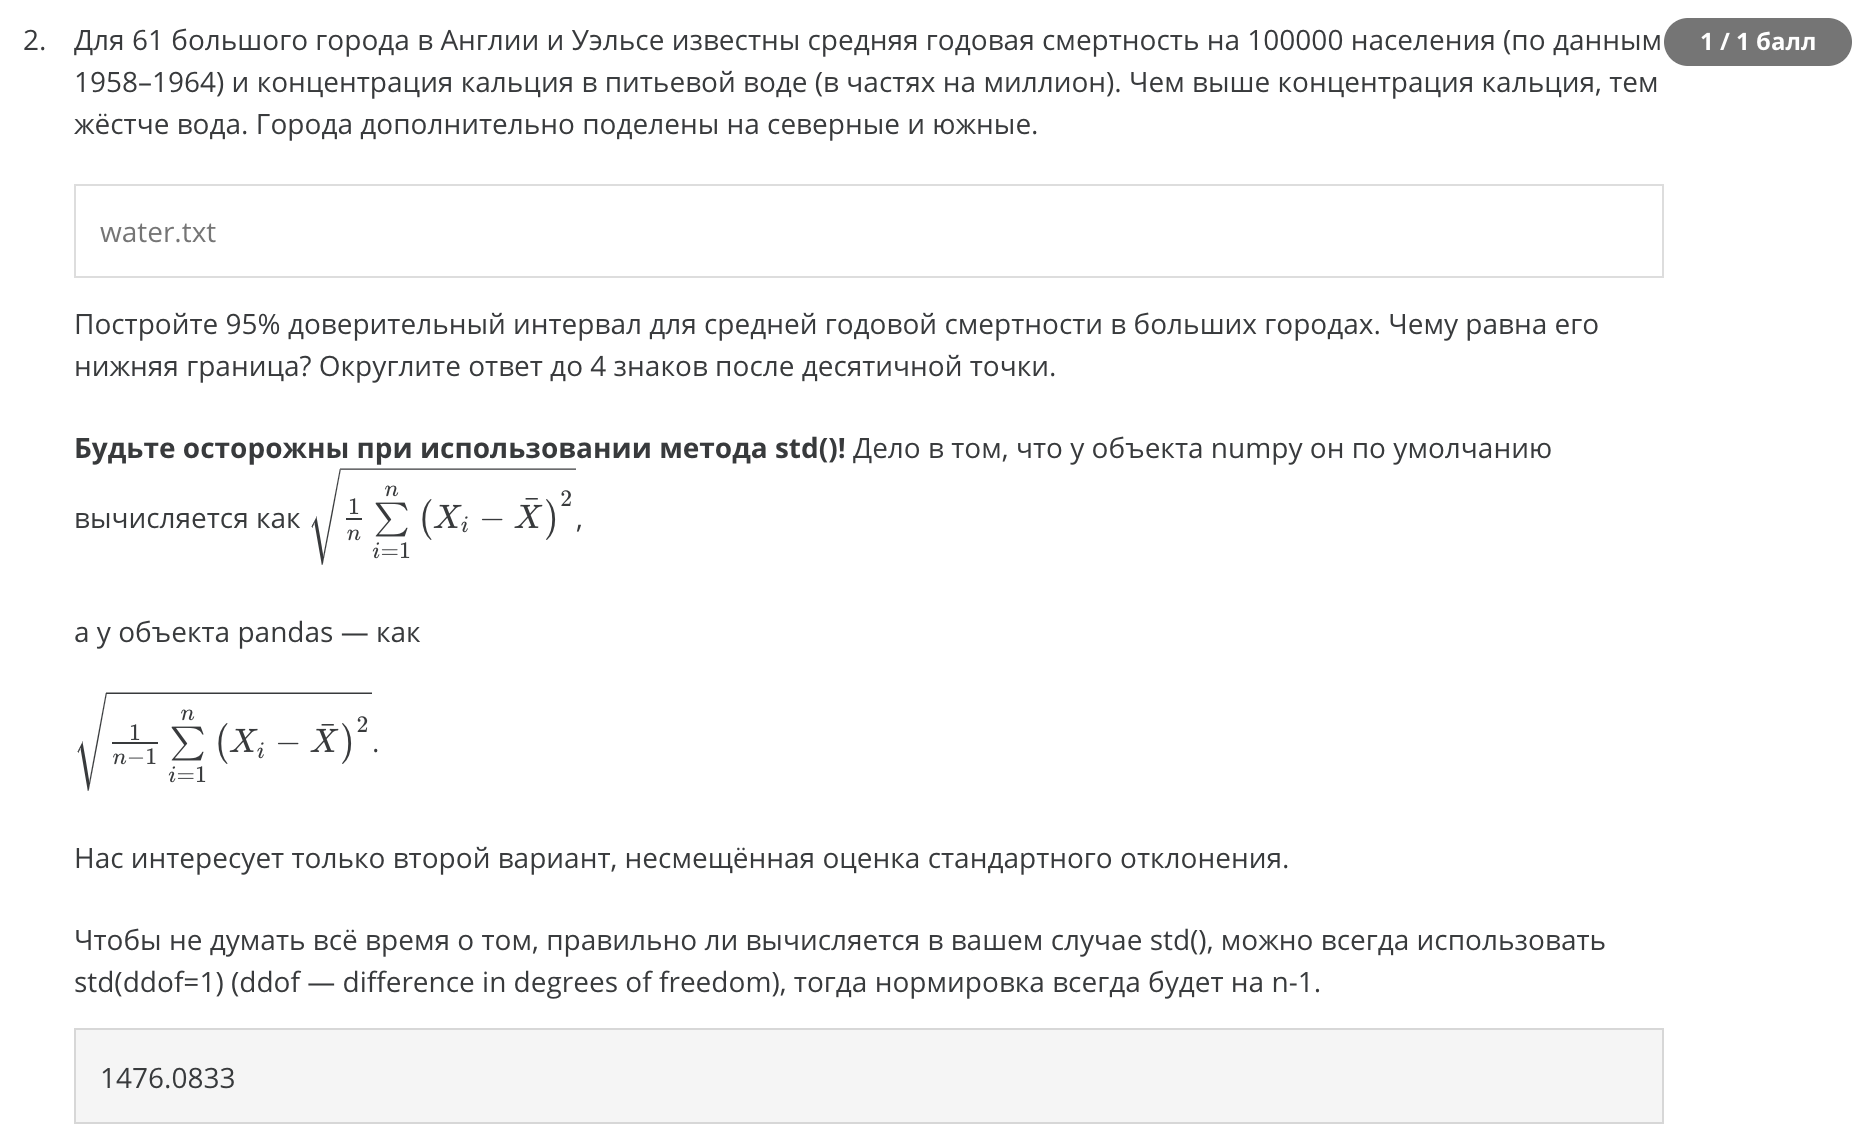

In [26]:
import pandas as pd

df = pd.read_csv('water.txt', sep='\t')

In [27]:
df

,location,town,mortality,hardness
0,South,Bath,1247,105
1,North,Birkenhead,1668,17
2,South,Birmingham,1466,5
3,North,Blackburn,1800,14
4,North,Blackpool,1609,18
...,...,...,...,...
56,South,Walsall,1527,60
57,South,West Bromwich,1627,53
58,South,West Ham,1486,122
59,South,Wolverhampton,1485,81


In [28]:
df.mortality.mean()

1524.1475409836066

In [29]:
df.mortality.std(ddof=1)

187.6687539314571

In [30]:
_tconfint_generic(df.mortality.mean(),
                  df.mortality.std(ddof=1) / sqrt(len(df.mortality)),
                  len(df.mortality) - 1,
                  0.05,
                  'two-sided')

(1476.0833413552848, 1572.2117406119285)

In [31]:
data = df
# правильный ответ
_tconfint_generic(data['mortality'].mean(), 
                  data['mortality'].std(ddof=1) / np.sqrt(len(data)),
                  len(data) - 1,
                  0.05,
                  'two-sided')

(1476.0833413552848, 1572.2117406119285)

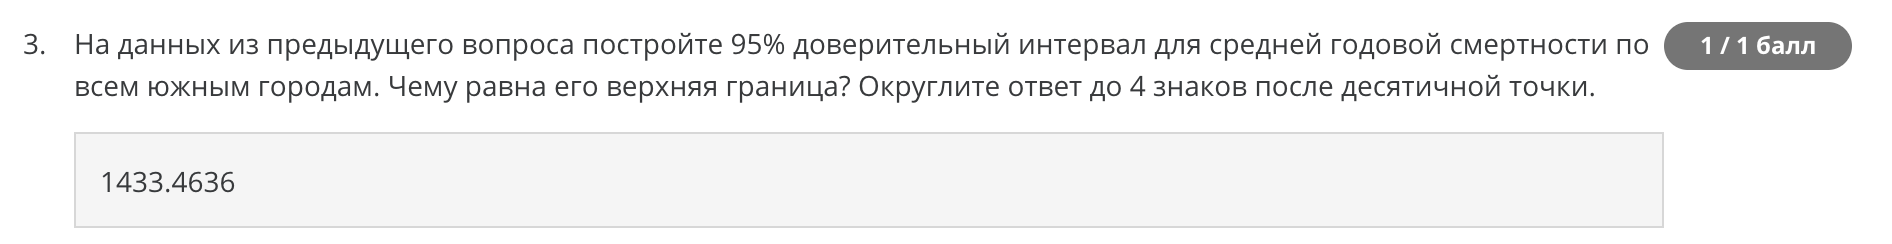

In [32]:
dfS = df[df.location == 'South']

In [33]:
_tconfint_generic(dfS.mortality.mean(),
                  dfS.mortality.std(ddof=1) / (len(dfS.mortality)**0.5),
                  len(dfS.mortality) - 1,
                  0.05,
                  'two-sided')

(1320.1517462936238, 1433.463638321761)

In [34]:
_tconfint_generic(data[data.location == 'South'].mortality.mean(),
                  data[data.location == 'South'].mortality.std(ddof=1) / np.sqrt(len(data[data.location == 'South'])),
                  len(data[data.location == 'South']) - 1,
                  0.05,
                  'two-sided')

(1320.1517462936238, 1433.463638321761)

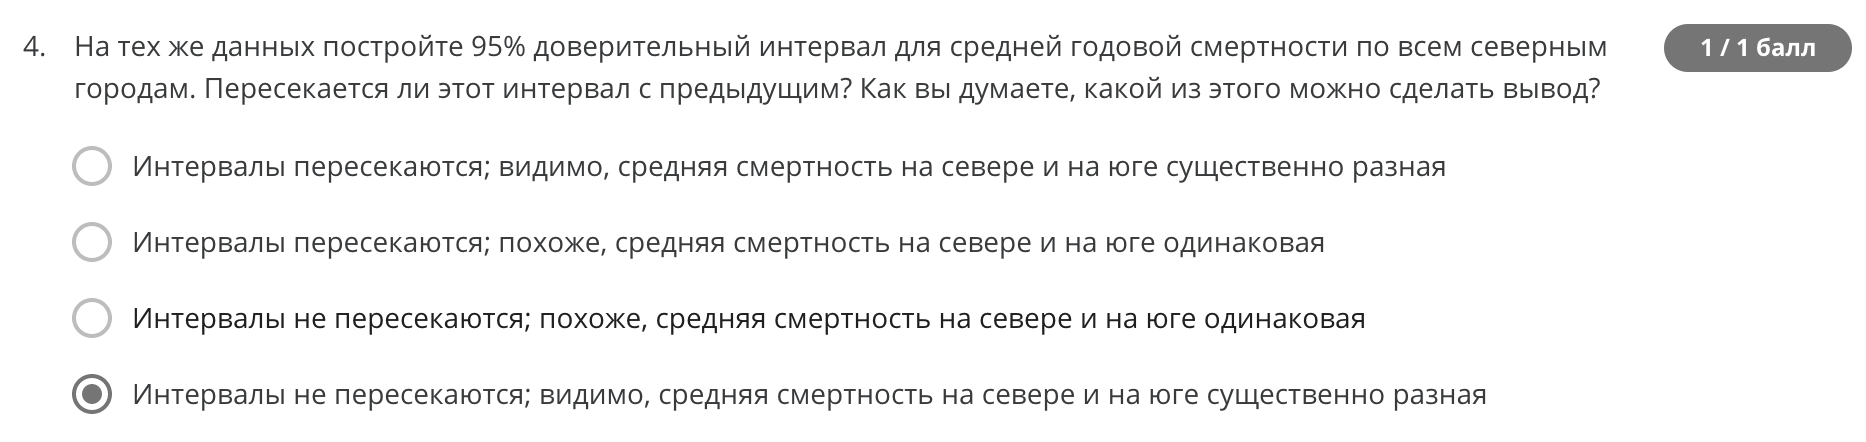

In [38]:
dfN = df[df.location == 'North']

In [39]:
_tconfint_generic(dfN.mortality.mean(),
                  dfN.mortality.std(ddof=1) / (len(dfN.mortality)**0.5),
                  len(dfN.mortality) - 1,
                  0.05,
                  'two-sided')

(1586.5605251961385, 1680.6394748038613)

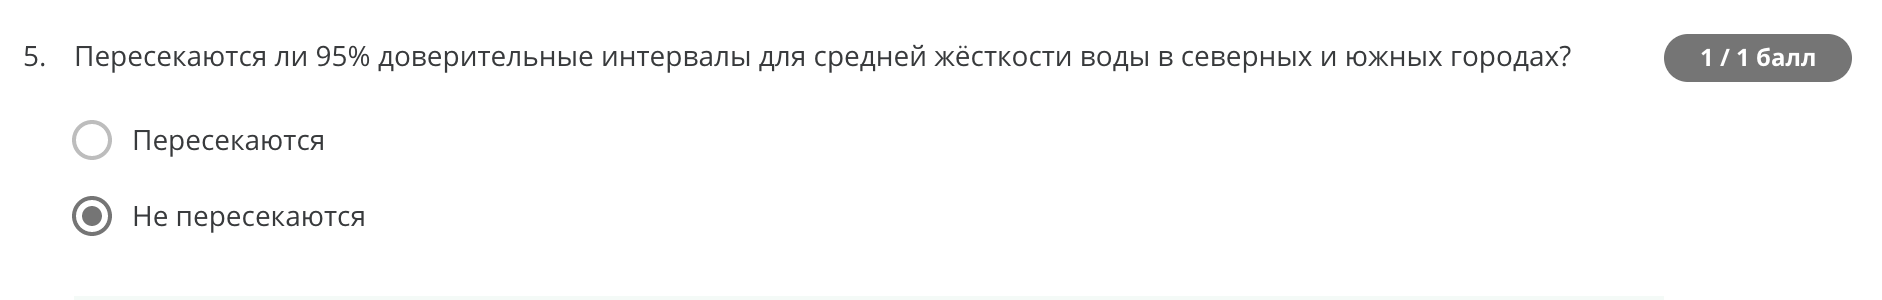

In [40]:
_tconfint_generic(dfN.hardness.mean(),
                  dfN.hardness.std(ddof=1) / (len(dfN.hardness)**0.5),
                  len(dfN.hardness) - 1,
                  0.05,
                  'two-sided')

(21.42248728572426, 39.37751271427574)

In [41]:
_tconfint_generic(dfS.hardness.mean(),
                  dfS.hardness.std(ddof=1) / (len(dfS.hardness)**0.5),
                  len(dfS.hardness) - 1,
                  0.05,
                  'two-sided')

(53.467198692036106, 86.07126284642544)

In [37]:
_tconfint_generic(data[data.location == 'South'].hardness.mean(), data[data.location == 'South'].hardness.std(ddof=1) / np.sqrt(len(data[data.location == 'South'])), len(data[data.location == 'South']) - 1, 0.05, 'two-sided')
_tconfint_generic(data[data.location == 'North'].hardness.mean(), data[data.location == 'North'].hardness.std(ddof=1) / np.sqrt(len(data[data.location == 'North'])), len(data[data.location == 'North']) - 1, 0.05, 'two-sided')

(21.42248728572426, 39.37751271427574)

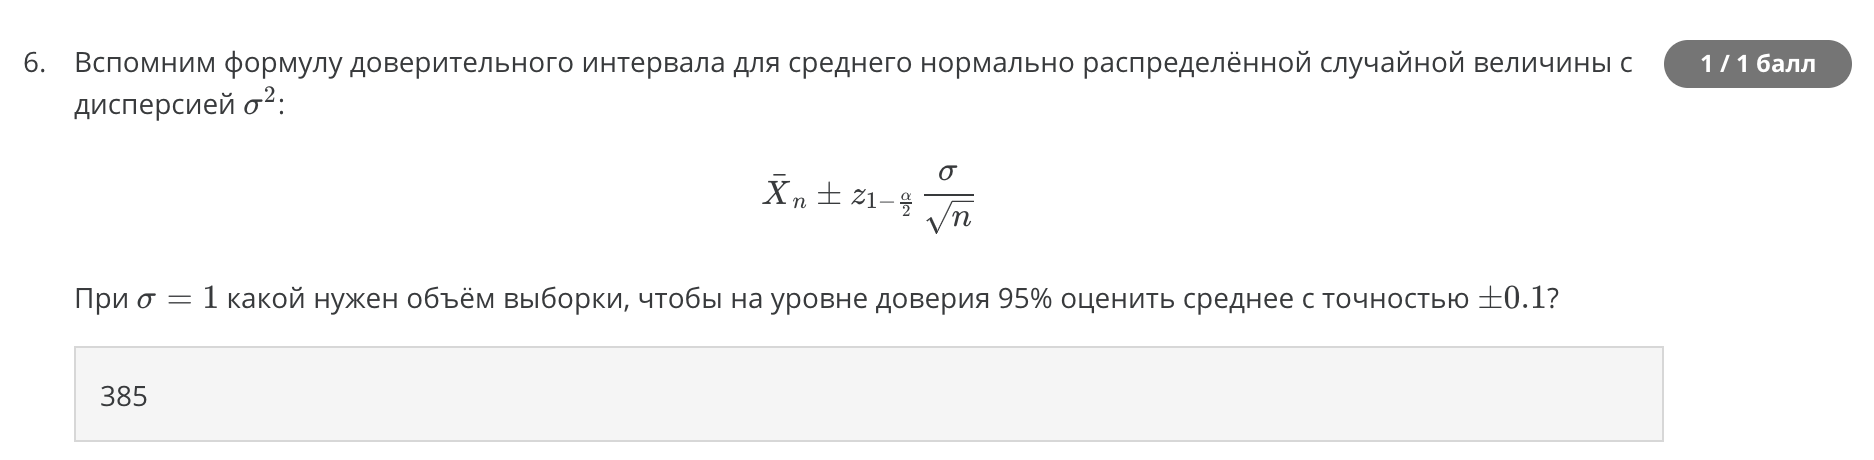

https://baguzin.ru/wp/opredelenie-obema-vyborki/

In [36]:
from scipy import stats

np.ceil((stats.norm.ppf(1-0.05/2) / 0.1)**2)

385.0

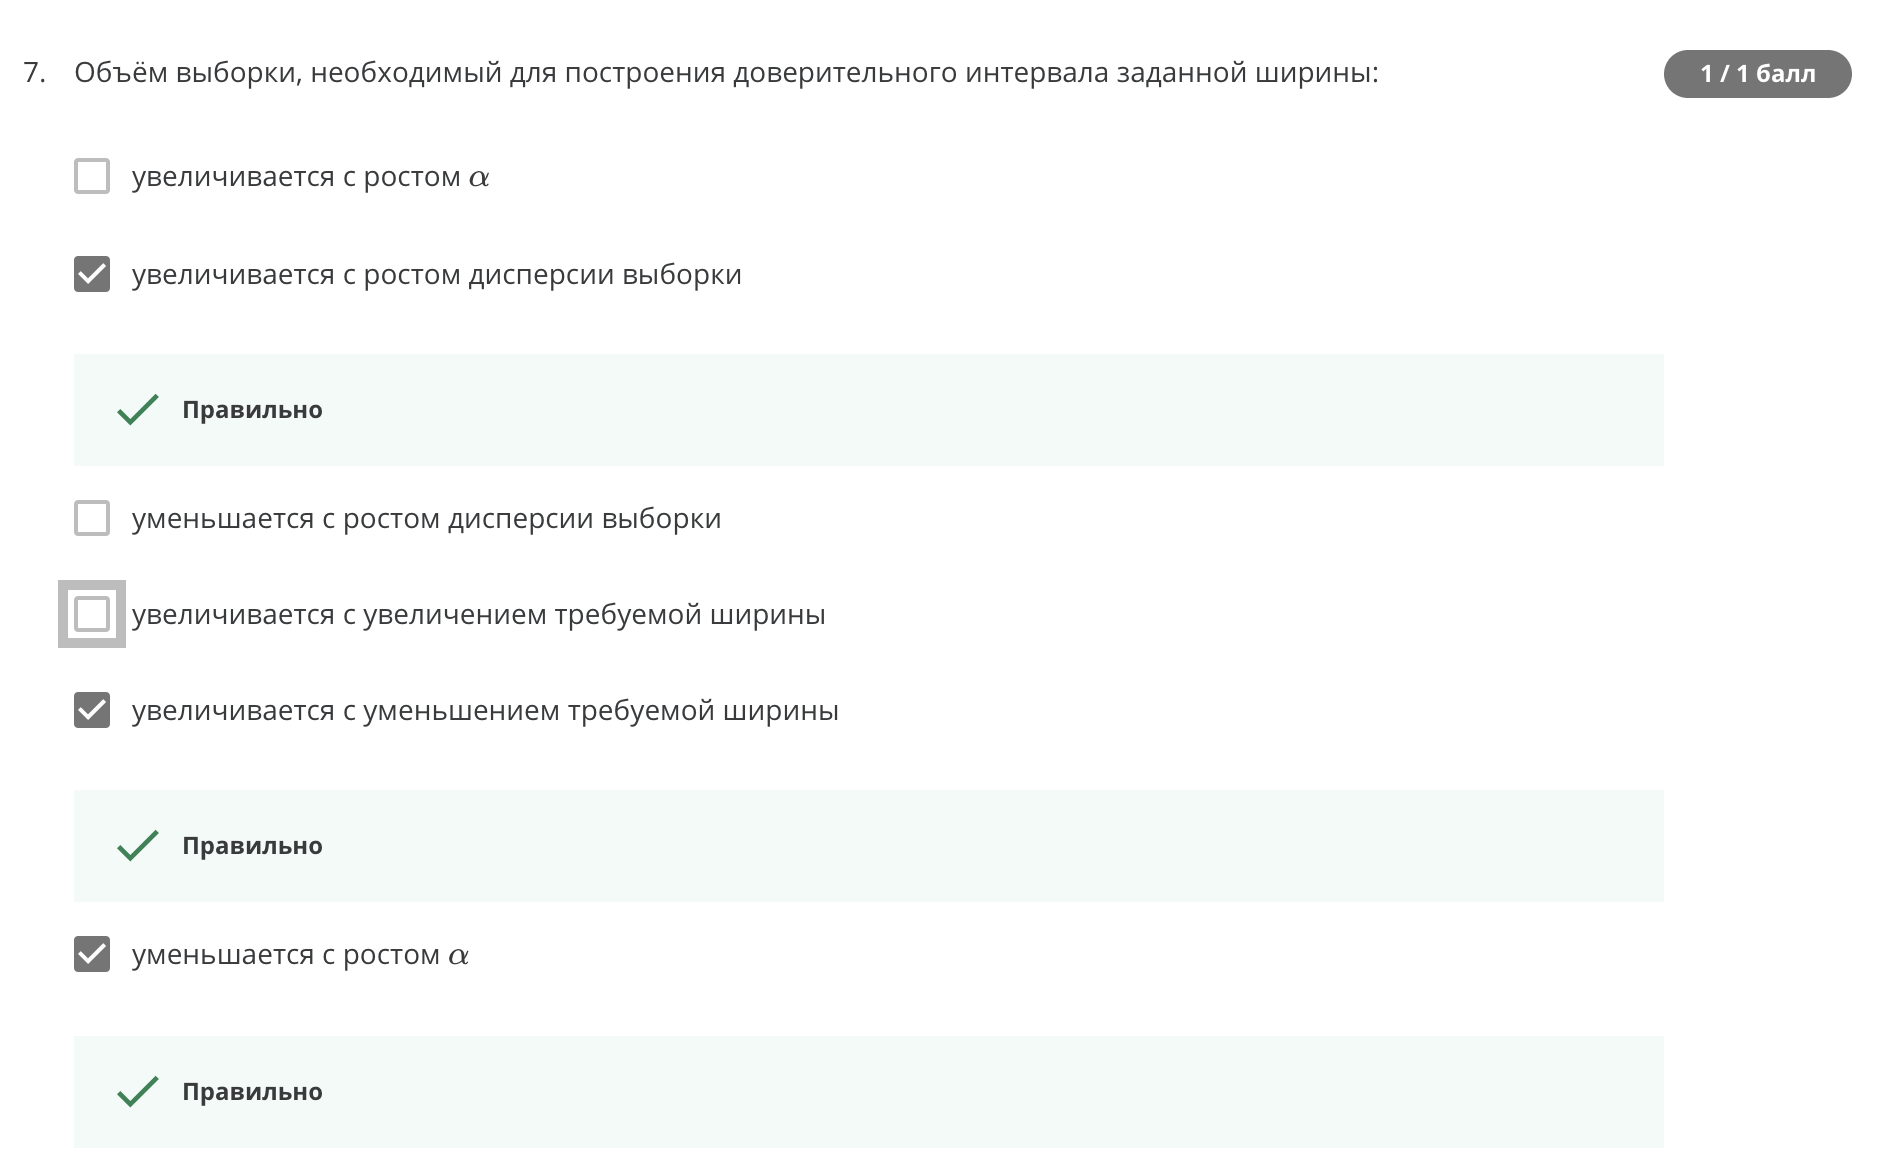